In [1]:
import matplotlib.pyplot as plt
import os, shutil
import cv2
import numpy as np
import pandas as pd
import seaborn as sns

## Load Data

In [6]:
train_data_path = "../../../02_data_crop/train"

images_per_folder = {}

for folder in os.listdir(train_data_path):
    len_images = len([name for name in os.listdir(os.path.join(train_data_path, folder)) if os.path.isfile(os.path.join(train_data_path, folder, name))])
    images_per_folder[folder] = len_images

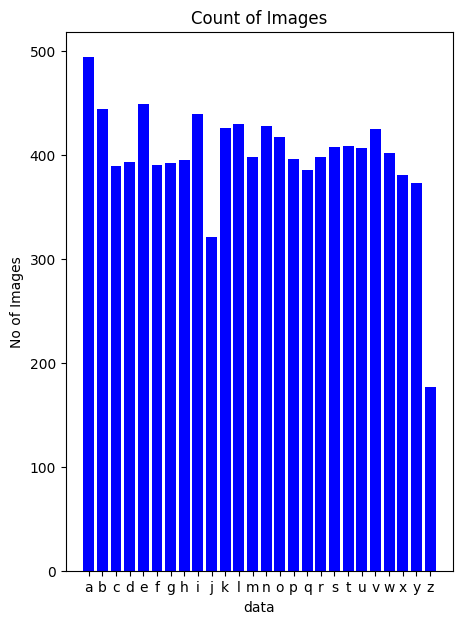

In [32]:
typex = images_per_folder.keys()
values = images_per_folder.values()

fig = plt.figure(figsize=(5,7))
plt.bar(typex, values, color="blue")
plt.xlabel('data')
plt.ylabel('No of Images')
plt.title('Count of Images')
plt.show()

In [7]:
test_data_path = "../../../02_data_crop/test"

images_per_folder = {}

for folder in os.listdir(test_data_path):
    len_images = len([name for name in os.listdir(os.path.join(test_data_path, folder)) if os.path.isfile(os.path.join(test_data_path, folder, name))])
    images_per_folder[folder] = len_images

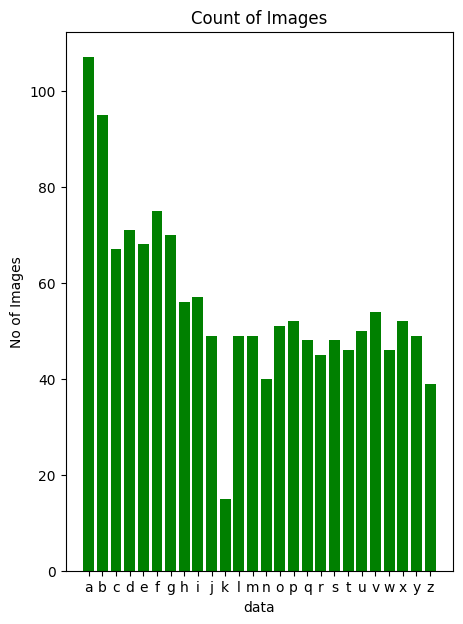

In [34]:
typex = images_per_folder.keys()
values = images_per_folder.values()

fig = plt.figure(figsize=(5,7))
plt.bar(typex, values, color="green")
plt.xlabel('data')
plt.ylabel('No of Images')
plt.title('Count of Images')
plt.show()

In [4]:
# all packages for training the model
import torch
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torch.utils.data import random_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


## load data

In [ ]:
# image = image.reshape((1,) + image.shape)

In [18]:
from sklearn.utils import shuffle
import keras
from natsort import natsorted

def load_data(images_path, image_size):
    X=[]
    y=[]
    folder = os.listdir(images_path)

    image_width, image_height = image_size

    for class_label in natsorted(folder):
        label = int(class_label)
        single_folder = os.path.join(images_path, class_label)

        for file in os.listdir(single_folder):
            filepath = os.path.join(single_folder, file)

            image = cv2.imread(filepath)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            #image = image.reshape((1,) + image.shape)

            X.append(image)
            y.append(label)
    
    X = np.array(X)
    y = np.array(y)
    y = keras.utils.to_categorical(y)

    X,y = shuffle(X,y)

    return X, y


IMAGE_WIDTH, IMAGE_HEIGHT = (64,64)
X_train,y_train = load_data(train_data_path, (IMAGE_WIDTH, IMAGE_HEIGHT))

In [9]:
print(X_train.shape)
print(y_train.shape)

(10368, 64, 64, 3)
(10368, 26)


In [19]:
IMAGE_WIDTH, IMAGE_HEIGHT = (64,64)
X_val,y_val = load_data(test_data_path, (IMAGE_WIDTH, IMAGE_HEIGHT))
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

X_val shape: (1448, 64, 64, 3)
y_val shape: (1448, 26)


In [13]:
train_datagen = ImageDataGenerator(rescale=1./255,
                   horizontal_flip=0.4,
                   vertical_flip=0.4,
                   rotation_range=40,
                   shear_range=0.2,
                   width_shift_range=0.4,
                   height_shift_range=0.4,
                   fill_mode='nearest')

val_data_gen = ImageDataGenerator(rescale=1./255)

In [16]:
train_generator = train_datagen.flow_from_directory(train_data_path, batch_size=64, target_size=(64,64), class_mode='categorical', shuffle=True, seed=42, color_mode='rgb')
val_generator = train_datagen.flow_from_directory(test_data_path, batch_size=64, target_size=(64,64), class_mode='categorical', shuffle=True, seed=42, color_mode='rgb')

Found 10368 images belonging to 26 classes.
Found 1448 images belonging to 26 classes.


In [20]:
class_labels = train_generator.class_indices
class_name = {value: key for (key, value) in class_labels.items()}
print(class_name)

{0: '0', 1: '1', 2: '10', 3: '11', 4: '12', 5: '13', 6: '14', 7: '15', 8: '16', 9: '17', 10: '18', 11: '19', 12: '2', 13: '20', 14: '21', 15: '22', 16: '23', 17: '24', 18: '25', 19: '3', 20: '4', 21: '5', 22: '6', 23: '7', 24: '8', 25: '9'}


## Model

In [21]:
base_model = VGG19(input_shape=(64,64,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(26, activation='sigmoid')(class_2)

model_01 = Model(base_model.input, output)
model_01.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4608)           │     9,441,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             

 Total params: 34,805,722 (132.77 MB)

 Trainable params: 14,781,338 (56.39 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [22]:
filepath = 'model.keras'
es = EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.0001)

In [23]:
sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model_01.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'] )

c:\Users\KimJu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [24]:
history_01 = model_01.fit(train_generator, steps_per_epoch=10, epochs=5, callbacks=[es,cp,lrr], validation_data=val_generator)

Epoch 1/5


c:\Users\KimJu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.0256 - loss: 3.3586
Epoch 1: val_loss improved from inf to 3.34369, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.0266 - loss: 3.3577 - val_accuracy: 0.0311 - val_loss: 3.3437 - learning_rate: 1.0000e-04
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.0383 - loss: 3.3909
Epoch 2: val_loss improved from 3.34369 to 3.28978, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.0385 - loss: 3.3876 - val_accuracy: 0.0345 - val_loss: 3.2898 - learning_rate: 1.0000e-04
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.0409 - loss: 3.3249
Epoch 3: val_loss improved from 3.28978 to 3.27293, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.0412 - loss: 3.3231 - val_accuracy: 0.0414 - val_loss: 3.2729 - learning_rate: 1.0000e-04
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.0591 - loss: 3.2833
Epoch

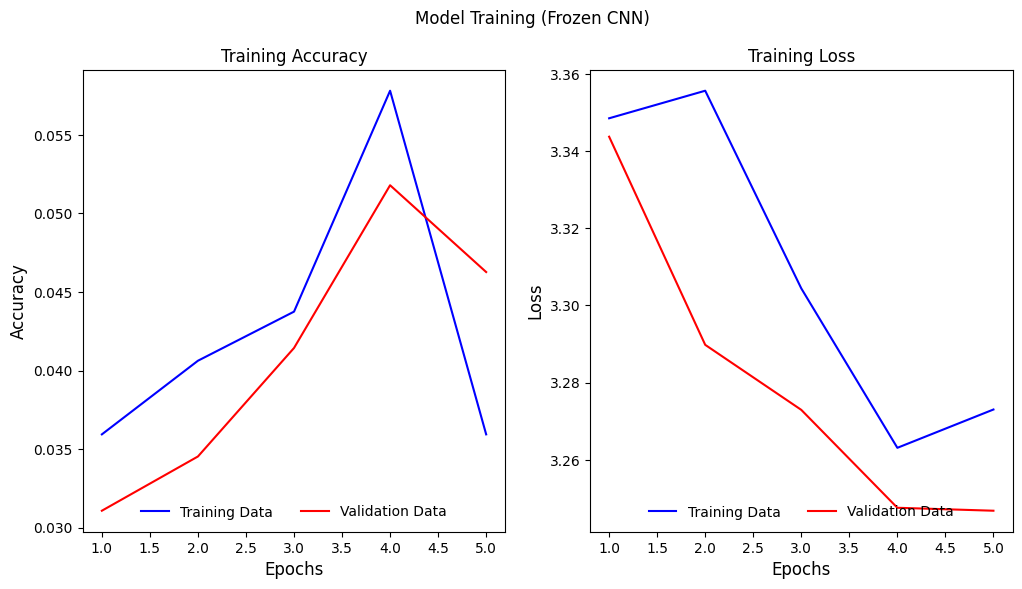

In [27]:
# plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle('Model Training (Frozen CNN)', fontsize=12)
max_epoch = len(history_01.history['accuracy']) + 1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_01.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_01.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax2.plot(epochs_list, history_01.history['loss'], color='b', linestyle='-', label='Training Data')
ax2.plot(epochs_list, history_01.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax2.set_title('Training Loss', fontsize=12)
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(frameon=False, loc='lower center', ncol=2)
plt.savefig('training_frozencnn.jpg', format='jpg', dpi=100, bbox_inches='tight')

In [32]:
model_01.save_weights('model_weights/vgg19_model_01.weights.h5', overwrite=True)

In [33]:
model_01.load_weights('model_weights/vgg19_model_01.weights.h5')
vgg_val_eval_01 = model_01.evaluate(val_generator)
#vgg_test_eval_01 = model_01.evaluate(test_generator)

23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 560ms/step - accuracy: 0.0505 - loss: 3.2470


In [34]:
print(f'Validation Loss: {vgg_val_eval_01[0]}')
print(f'Validation acc: {vgg_val_eval_01[1]}')
#print(f'Testing Loss: {vgg_test_eval_01[0]}')
#print(f'Testing acc: {vgg_test_eval_01[1]}')

Validation Loss: 3.240645408630371
Validation acc: 0.05455801263451576


In [ ]:
filenames = test_generator.filenames
nb_sample = len(filenames)
vgg_prediction_01 = model_01.predict(test_generator, steps=nb_sample, verbose=1)
y_pred = np.argmax(vgg_prediction_01, axis=1)

## Incremental unfreezing und fine tuning

In [ ]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('model_weights.h5')

set_trainable=False
for layer in base_model.layers:
    if layer.name in ['block5_conv4', 'block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

In [ ]:
sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model_02.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'] )

In [ ]:
history_02 = model_02.fit(train_generator, steps_per_epoch=10, epochs=20, callbacks=[es,cp,lrr], validation_data=val_genrerator)

In [ ]:
# plot performance
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
fig.suptitle('Model Training (Frozen CNN)', fontsize=12)
max_epoch = len(history_02.history['accuracy']) + 1
epochs_list = list(range(1, max_epoch))

ax1.plot(epochs_list, history_02.history['accuracy'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_02.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Accuracy', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)

ax1.plot(epochs_list, history_02.history['loss'], color='b', linestyle='-', label='Training Data')
ax1.plot(epochs_list, history_02.history['val_loss'], color='r', linestyle='-', label='Validation Data')
ax1.set_title('Training Loss', fontsize=12)
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(frameon=False, loc='lower center', ncol=2)
plt.savefig('training_frozencnn.jpg', fomrat='jpg', dpi=100, bbox_inches='tight')

In [ ]:
model_01.save_weights('model_weights_model_02.h5', overwrite=True)

In [ ]:
model_02.load_weights('model_weights_model_02.h5')
vgg_val_eval_02 = model_02.evaluate(val_genrator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

In [ ]:
# unfreezing the entire network
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation='relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(drop_out)
output = Dense(2, activation='softmax')(class_2)

model_03 = Model(base_model.inputs, output)
model_03.load_weights('model_weights_model_02.h5')

In [ ]:
sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model_03.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'] )

In [ ]:
model_03.summary()

In [ ]:
history_03 = model_03.fit(train_generator, steps_per_epoch=10, epochs=20, callbacks=[es,cp,lrr], validation_data=val_genrerator)

In [ ]:
model_03.load_weights('model_weights_unfrozen.h5')
vgg_val_eval_03 = model_03.evaluate(val_genrator)
vgg_test_eval_03 = model_03.evaluate(test_generator)